<a href="https://colab.research.google.com/github/apallath/cats_vs_dogs_models/blob/main/cats_vs_dogs_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
import os, shutil
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG19

In [3]:
# Load subset of Cats v/s Dogs image dataset
train_cats = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/train/cats'
train_dogs = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/train/dogs'
val_cats = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/val/cats'
val_dogs = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/val/dogs'
test_cats = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/test/cats'
test_dogs = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/test/dogs'

print(len(os.listdir(train_cats)))
print(len(os.listdir(train_dogs)))
print(len(os.listdir(val_cats)))
print(len(os.listdir(val_dogs)))
print(len(os.listdir(test_cats)))
print(len(os.listdir(test_dogs)))

# Use Keras ImageDataGenerator to create train, val, and test datasets
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/colab_data/cats_vs_dogs_small/train/',
                                              target_size=(150, 150),
                                              batch_size=20,
                                              class_mode='binary')

val_gen = val_datagen.flow_from_directory('/content/drive/MyDrive/colab_data/cats_vs_dogs_small/val/',
                                              target_size=(150, 150),
                                              batch_size=20,
                                              class_mode='binary')

1000
1000
500
500
500
500
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
model = models.Sequential()

# VGG19 conv base
base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model.add(base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

80142336/80134624 [==============================] - 1s 0us/step


# Step 1: Freeze conv base, train dense block.

In [5]:
base.trainable = False

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


In [7]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(train_gen,
                    steps_per_epoch=100, #2000 = 100 * 20
                    epochs=30,
                    validation_data=val_gen,
                    validation_steps=50) #1000 = 50 * 20

Epoch 1/30
100/100 [==============================] - 1108s 11s/step - loss: 0.9199 - accuracy: 0.6362 - val_loss: 0.3126 - val_accuracy: 0.8650
Epoch 2/30
100/100 [==============================] - 22s 224ms/step - loss: 0.4455 - accuracy: 0.7923 - val_loss: 0.2983 - val_accuracy: 0.8750
Epoch 3/30
100/100 [==============================] - 22s 221ms/step - loss: 0.4272 - accuracy: 0.7956 - val_loss: 0.2888 - val_accuracy: 0.8680
Epoch 4/30
100/100 [==============================] - 22s 219ms/step - loss: 0.4127 - accuracy: 0.8129 - val_loss: 0.2970 - val_accuracy: 0.8660
Epoch 5/30
100/100 [==============================] - 22s 220ms/step - loss: 0.3768 - accuracy: 0.8414 - val_loss: 0.2837 - val_accuracy: 0.8820
Epoch 6/30
100/100 [==============================] - 22s 219ms/step - loss: 0.4273 - accuracy: 0.8107 - val_loss: 0.3015 - val_accuracy: 0.8760
Epoch 7/30
100/100 [==============================] - 22s 218ms/step - loss: 0.3806 - accuracy: 0.8182 - val_loss: 0.3166 - val_ac

In [9]:
model.save('/content/drive/MyDrive/colab_models/cats_vs_dogs_vgg19_dense.h5')

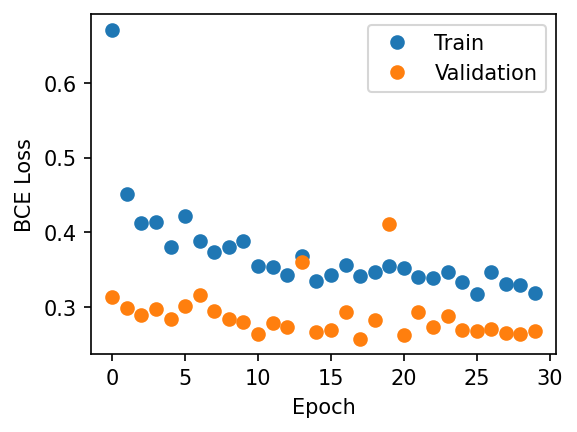

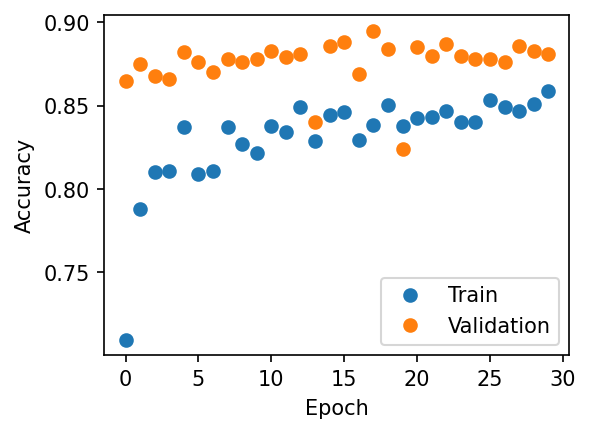

In [10]:
n_epochs = 30

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(range(n_epochs), history.history['loss'], 'o', label="Train")
ax.plot(range(n_epochs), history.history['val_loss'], 'o', label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("BCE Loss")
ax.legend()

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(range(n_epochs), history.history['accuracy'], 'o', label="Train")
ax.plot(range(n_epochs), history.history['val_accuracy'], 'o', label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

# Step 2: Fine tune last conv block and dense block

In [11]:
# Unfreeze block 5
base.trainable = True

for layer in base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']:
        print(layer.name)
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gen,
                    steps_per_epoch=100, #2000 = 100 * 20
                    epochs=30,
                    validation_data=val_gen,
                    validation_steps=50) #1000 = 50 * 20

block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
Epoch 1/30
100/100 [==============================] - 24s 232ms/step - loss: 0.3309 - accuracy: 0.8526 - val_loss: 0.2739 - val_accuracy: 0.8900
Epoch 2/30
100/100 [==============================] - 23s 229ms/step - loss: 0.2845 - accuracy: 0.8686 - val_loss: 0.2192 - val_accuracy: 0.9130
Epoch 3/30
100/100 [==============================] - 23s 232ms/step - loss: 0.2270 - accuracy: 0.9008 - val_loss: 0.2158 - val_accuracy: 0.9140
Epoch 4/30
100/100 [==============================] - 24s 241ms/step - loss: 0.2108 - accuracy: 0.9132 - val_loss: 0.2324 - val_accuracy: 0.9110
Epoch 5/30
100/100 [==============================] - 24s 236ms/step - loss: 0.2034 - accuracy: 0.9138 - val_loss: 0.2069 - val_accuracy: 0.9180
Epoch 6/30
100/100 [==============================] - 22s 224ms/step - loss: 0.1798 - accuracy: 0.9234 - val_loss: 0.2353 - val_accuracy: 0.9110
Epoch 7/30
100/100 [==============================] - 23s 228ms/st

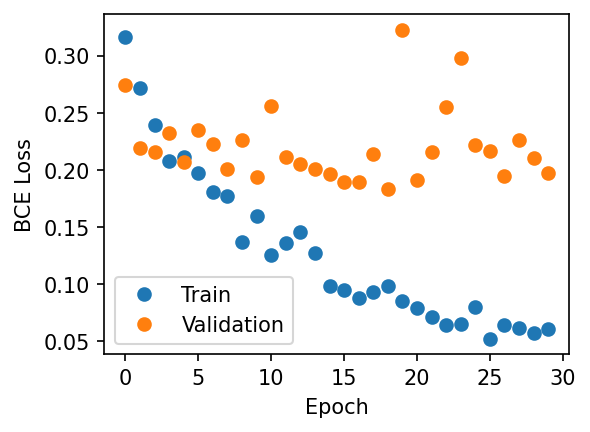

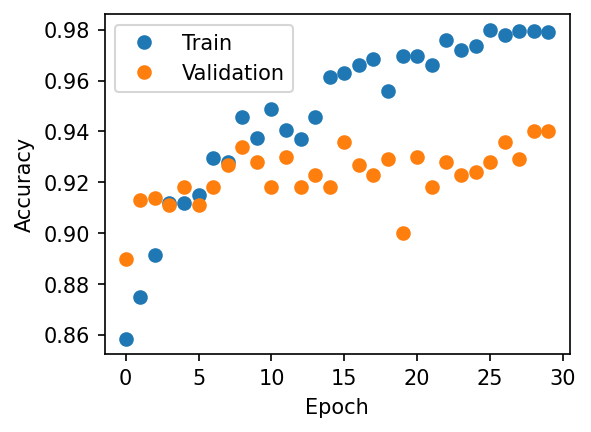

In [12]:
n_epochs = 30

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(range(n_epochs), history.history['loss'], 'o', label="Train")
ax.plot(range(n_epochs), history.history['val_loss'], 'o', label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("BCE Loss")
ax.legend()

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(range(n_epochs), history.history['accuracy'], 'o', label="Train")
ax.plot(range(n_epochs), history.history['val_accuracy'], 'o', label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

In [13]:
model.save('/content/drive/MyDrive/colab_models/cats_vs_dogs_vgg19_fine_tuned.h5')

# Step 3: Test eval

In [14]:
# Test eval
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_gen = test_datagen.flow_from_directory('/content/drive/MyDrive/colab_data/cats_vs_dogs_small/test/',
                                            target_size=(150, 150),
                                            batch_size=20,
                                            class_mode='binary')

test_loss, test_acc = model.evaluate(test_gen, steps=50)

print(test_loss)
print(test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 339s 7s/step - loss: 0.2418 - accuracy: 0.9390
0.24182948470115662
0.9390000104904175


(150, 150, 3)
True:  Cat | Predicted:  Cat


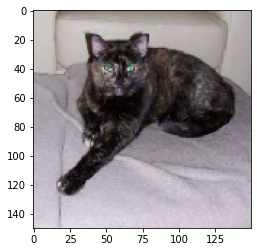

In [15]:
# Prediction
classes = ['Cat', 'Dog']

catsdogs = [test_cats, test_dogs]

true = np.random.randint(0, 2)

picked = catsdogs[true]
fnames = [os.path.join(picked, fname) for fname in os.listdir(picked)]
img_path = fnames[np.random.randint(0, 500)]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img) / 255.0
print(x.shape)
plt.imshow(x)

predicted = model.predict(x.reshape(1, 150, 150, 3))

print("True: ", classes[true], "| Predicted: ", classes[int(predicted > 0.5)])